# Rainfall-runoff experiment

In this experiment, we'll try to learn model for simple artificial dataset of simulated rainfall-runoff scenario.

The task is to forecast runoff (prutok) based on rainfall during time. We can test longer dependencies through time and power of LSTM networks.

In [171]:
%tensorflow_version 2.x
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN
from tensorflow import keras
import tensorflow as tf

from tqdm.notebook import tqdm

First, we need a dataset. Here's a code that simulates one river scenario.

There are two methods: `get_precip` for rainfall and `gen_discharge` for runoff. Runoff is lagged in time based on topography of the river (see `BASINS = [BASIN(area, lag)]` array)

In [124]:
MIN_EVENT_TIME = 5
MAX_EVENT_TIME = 20
MIN_EVENT_POWER = 0.05
MAX_EVENT_POWER = 0.5

BASINS = np.array([
    (1, 5),
    (2, 20),
    (2, 30),
    (1, 35),
    (3, 41),
    (2, 45),
    (1, 54),
    (2, 65),
    (1, 75),
])

def generate_precipitation(num_samples, events_ratio):  
    
    result = np.zeros(num_samples)
    num_events = int(events_ratio * num_samples)
    
    for event_start in random.sample(range(num_samples - MAX_EVENT_TIME), num_events):
        event = np.zeros((num_samples,))
        event_time = random.randint(MIN_EVENT_TIME, MAX_EVENT_TIME)
        event_power = random.random() * (MAX_EVENT_POWER - MIN_EVENT_POWER) + MIN_EVENT_POWER
        event[event_start: event_start + event_time] = (np.cos(np.linspace(-np.pi, np.pi, num=event_time)) * 0.5 + 0.5) * event_power
        result += event
    
    return result

def generate_discharge(basins, precip, runoff):            

    volumes = np.zeros((len(basins),len(precip)))
    discharges = np.zeros((len(basins),len(precip)))
    for i, p in enumerate(precip):      
        discharges[:,i] = volumes[:,i-1] * runoff
        volumes[:,i] = basins[:,0] * p + volumes[:,i-1] * (1 -runoff)        
    
    
    sum_discharge = np.zeros(len(precip))
    for d, basin in zip(discharges, basins):        
        lag = int(basin[1])
        lagged = np.roll(d, lag)
        lagged[:lag] = 0.0
        sum_discharge += lagged    
        
    return sum_discharge

Let's see how our simulated river behaves:

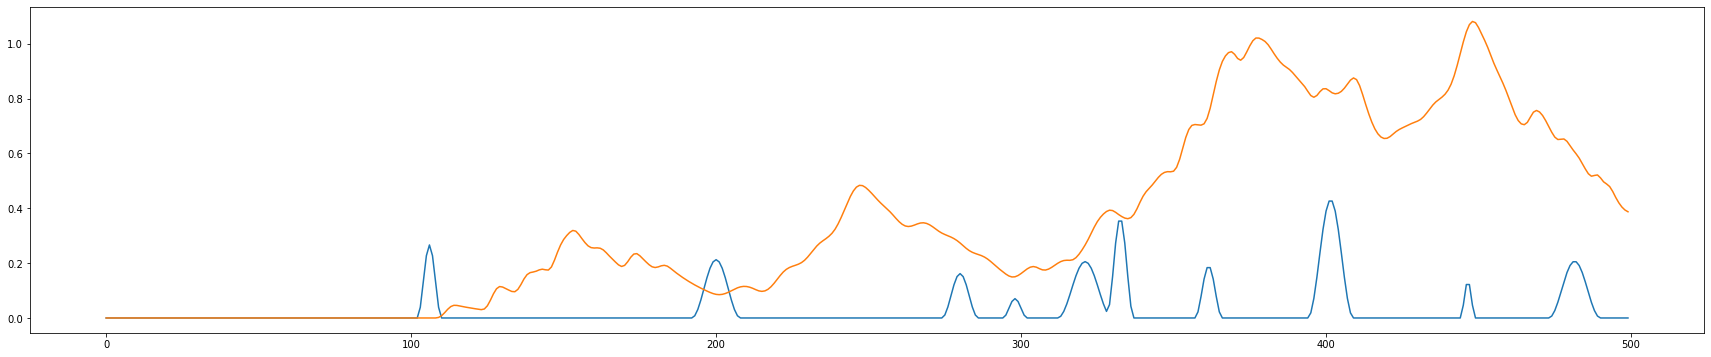

In [125]:
precip = generate_precipitation(500, 0.02)
discharge = generate_discharge(BASINS, precip, 0.05)

plt.figure(figsize=(30,6))
plt.plot(precip)
plt.plot(discharge)
plt.show()

We can generate some training examples for this river and try fit a neural network model to see if the model can learn the river hidden behavior.

In [126]:
import random

NUM_SAMPLES = 2000
SEQ_LEN = 500

raw_train_X = [generate_precipitation(SEQ_LEN, 0.02) for i in tqdm(range(NUM_SAMPLES))]
raw_train_Y = [generate_discharge(BASINS, precip_sample, 0.05) for precip_sample in tqdm(raw_train_X)]

## Feed-forward network

In [290]:
inputs = Input(shape=(SEQ_LEN,))
x = Dense(200, activation='tanh')(inputs)
x = Dense(200, activation='tanh')(x)
x = Dense(200, activation='tanh')(x)
outputs = Dense(SEQ_LEN, activation='relu')(x)

fnn_model = Model(inputs, outputs)
fnn_model.compile(optimizer='adam', loss='mse')
fnn_model.summary()

fnn_train_X = np.vstack(raw_train_X)
fnn_train_Y = np.vstack(raw_train_Y)

print("Input shape:", fnn_train_X.shape)
print("Target shape:", fnn_train_Y.shape)

Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
dense_32 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_33 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_34 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_35 (Dense)             (None, 500)               100500    
Total params: 281,100
Trainable params: 281,100
Non-trainable params: 0
_________________________________________________________________
Input shape: (2000, 500)
Target shape: (2000, 500)


In [291]:
progress = fnn_model.fit(fnn_train_X, fnn_train_Y, validation_split=0.1, epochs=25)

Epoch 1/25
57/57 [==============================] - 1s 10ms/step - loss: 0.1869 - val_loss: 0.0252
Epoch 2/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0185 - val_loss: 0.0070
Epoch 3/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0048
Epoch 4/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 5/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 6/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 7/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 8/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 9/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 10/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 11/25
57/57 

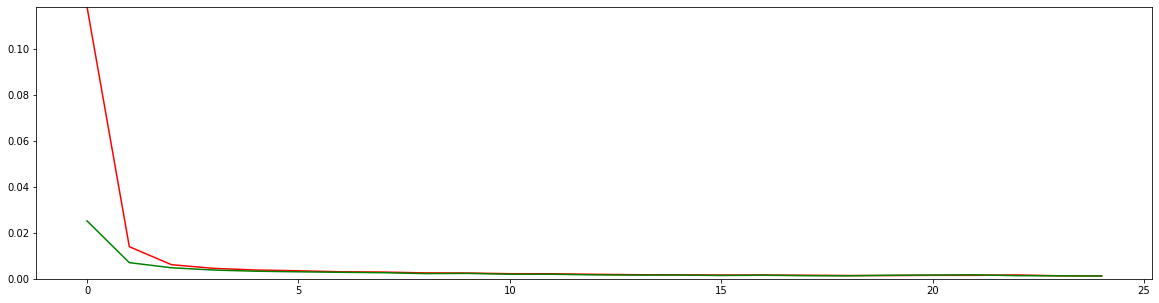

In [292]:
loss_history = np.array(progress.history['loss'])
val_loss_history = np.array(progress.history['val_loss'])
                            
plt.figure(figsize=(20,5))
plt.ylim(ymin=0, ymax=max(np.max(loss_history), np.max(val_loss_history)))
plt.plot(loss_history, 'r-')
plt.plot(val_loss_history, 'g-')
plt.show()

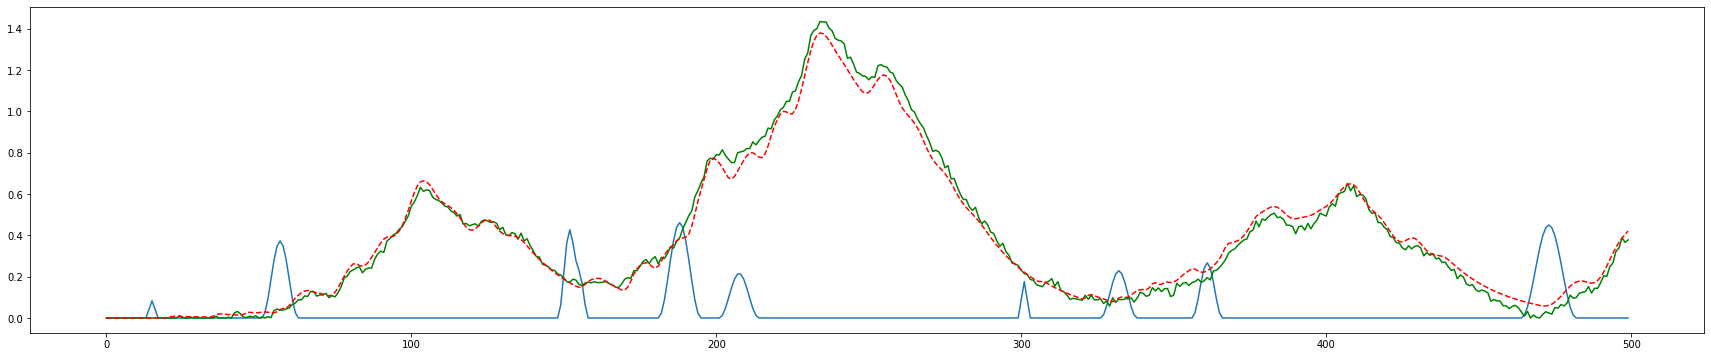

In [293]:
TEST_SEQ_LEN = 500
test_input = generate_precipitation(TEST_SEQ_LEN, 0.02)
test_output = generate_discharge(BASINS, test_input, 0.05)

prediction = fnn_model.predict(test_input.reshape(1, SEQ_LEN))[0]

plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(prediction, 'green')
plt.plot(test_output, 'r--')
plt.show()

## Recurrent network

In [150]:
inputs = Input(shape=(None, 1))
x = LSTM(64, return_sequences=True)(inputs)
outputs = Dense(1, activation='relu')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

train_X = np.vstack(raw_train_X)
train_Y = np.vstack(raw_train_Y)

print("Input shape:", train_X.shape)
print("Target shape:", train_Y.shape)

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, None, 1)]         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          16896     
_________________________________________________________________
dense_26 (Dense)             (None, None, 1)           65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Input shape: (2000, 500)
Target shape: (2000, 500)


In [153]:
progress = model.fit(train_X, train_Y, validation_split=0.1, epochs=15)

Epoch 1/15
57/57 [==============================] - 1s 21ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 2/15
57/57 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3/15
57/57 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/15
57/57 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/15
57/57 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/15
57/57 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/15
57/57 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/15
57/57 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/15
57/57 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/15
57/57 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 11/

In [168]:
model.save_weights("rr_lstm.npy")

In [154]:
TEST_SEQ_LEN = 2000
test_input = generate_precipitation(TEST_SEQ_LEN, 0.02)
test_output = generate_discharge(BASINS, test_input, 0.05)

In [155]:
prediction = model.predict(test_input.reshape((1, TEST_SEQ_LEN, 1)))[0]

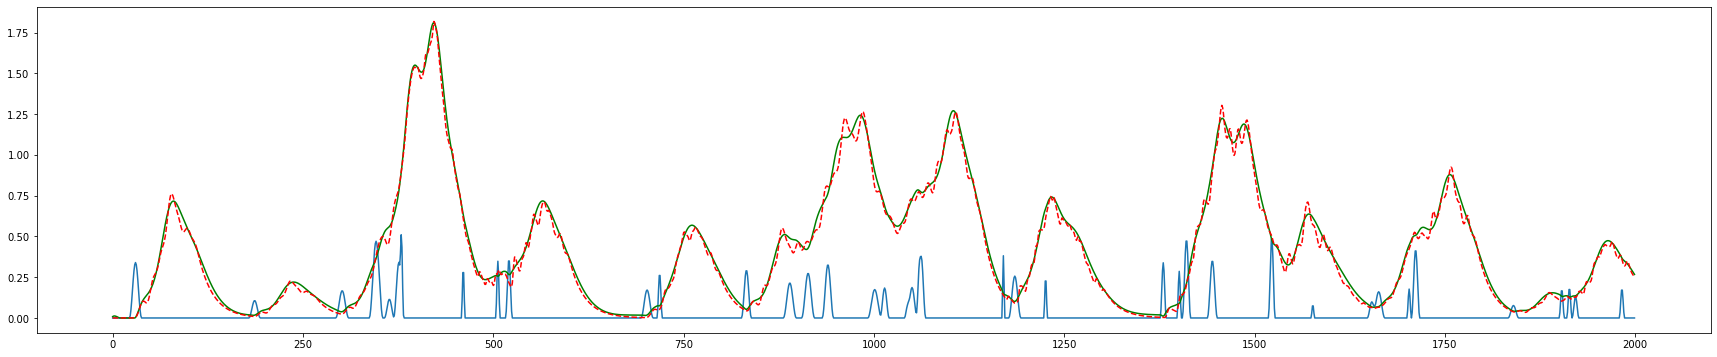

In [156]:
plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(prediction, 'green')
plt.plot(test_output, 'r--')
plt.show()

## Sliding window feed forward network
Feed-forward network can be used for longer inputs by "sliding" it over the whole input interval. It needs to have only one output and the training data must be padded accordingly.

In [157]:
inputs = Input(shape=(SEQ_LEN,))
x = Dense(200, activation='relu')(inputs)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
outputs = Dense(1, activation='relu')(x)

sliding_model = Model(inputs, outputs)
sliding_model.compile(optimizer='adam', loss='mse')
sliding_model.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
dense_27 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_28 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_29 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 51        
Total params: 125,401
Trainable params: 125,401
Non-trainable params: 0
_________________________________________________________________


For the training set, we would slide over each sampled sequence step by step and crete as many new training samples as steps in the sequence minus some reasonable minimal window at the beginining.

Another option is to generate very long raw sequence and then sample all the training data in one sweep (not implemented here)

In [305]:
MIN_WINDOW = 50

sliding_train_X = []
sliding_train_Y = []

for offset in range(MIN_WINDOW, SEQ_LEN + 1):
    x = np.roll(fnn_train_X, -offset, axis=-1)
    x[:,:-offset] = 0
    sliding_train_X.extend(x)
    sliding_train_Y.append(fnn_train_Y[:,offset-1])

In [160]:
sliding_train_X = np.vstack(sliding_train_X)
sliding_train_Y = np.concatenate(sliding_train_Y)

print("Input shape:", sliding_train_X.shape)
print("Target shape:", sliding_train_Y.shape)

Input shape: (902000, 500)
Target shape: (902000,)


In [161]:
progress = sliding_model.fit(sliding_train_X, sliding_train_Y, validation_split=0.1, epochs=1)

25369/25369 [==============================] - 55s 2ms/step - loss: 0.0013 - val_loss: 1.1032e-04


In [301]:
TEST_SEQ_LEN = 2000
test_input = generate_precipitation(TEST_SEQ_LEN, 0.02)
test_output = generate_discharge(BASINS, test_input, 0.05)

sliding_input = []
for offset in range(MIN_WINDOW, TEST_SEQ_LEN + 1):
    x = np.roll(test_input, -offset, axis=-1)
    x[:-offset] = 0
    sliding_input.append(x[-SEQ_LEN:])

prediction = np.concatenate((
    np.zeros(MIN_WINDOW-1),
    sliding_model.predict(np.vstack(sliding_input)).squeeze()
))

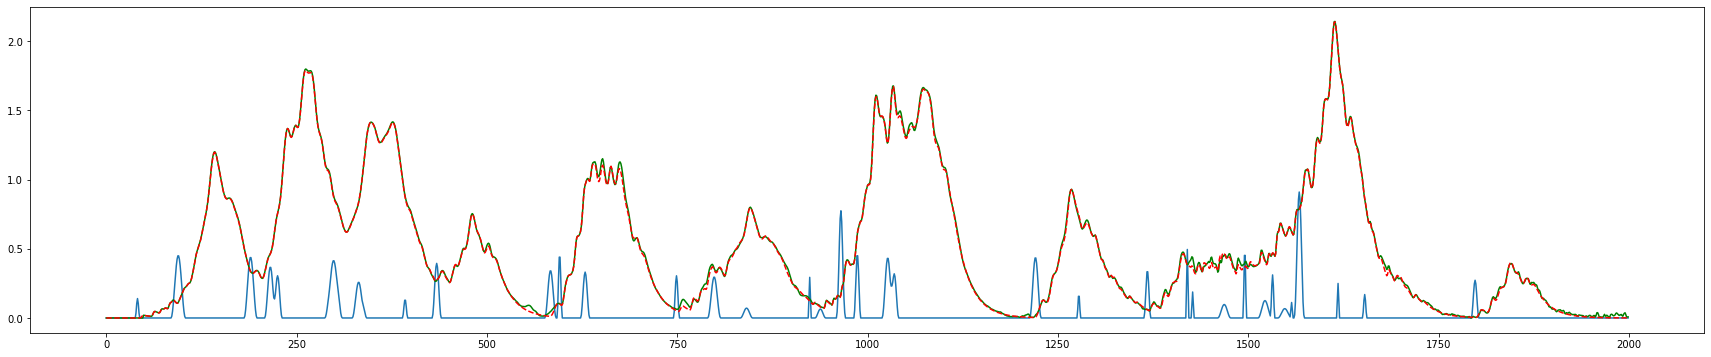

In [165]:
plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(prediction, 'green')
plt.plot(test_output, 'r--')
plt.show()

## Continuous prediction with LSTM network
LSTM can be used for daily prediction inslead of prediction on the full input.

We are **not** going to compile the model. 
We do not need training and inference will be much faster without gradient tracking turned off.

In [166]:
inputs = Input(batch_shape=(1, 1, 1))
x = LSTM(64, return_sequences=True, recurrent_activation='sigmoid', stateful=True)(inputs)
outputs = Dense(1, activation='linear')(x)
c_model = Model(inputs, outputs)
# c_model.compile(optimizer='adam', loss='mse')
c_model.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(1, 1, 1)]               0         
_________________________________________________________________
lstm_3 (LSTM)                (1, 1, 64)                16896     
_________________________________________________________________
dense_31 (Dense)             (1, 1, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


We are using the **same LSTM model instance** as above! Only sequence length is different.

In [169]:
c_model.load_weights("rr_lstm.npy")

First, the model is filled with the context from history

In [302]:
START_OFFSET = 150
HISTORY_LEN = 500
PREDICTION_LEN = len(test_input) - HISTORY_LEN - START_OFFSET

c_prediction = START_OFFSET * [0]
c_model.reset_states()

for i in tqdm(range(HISTORY_LEN)):
    single_pred = c_model.predict(test_input[i + START_OFFSET].reshape(1, 1, 1))[0][0][0]
    c_prediction.append(single_pred)

Next, the model predicts output day by day

In [303]:
for i in tqdm(range(PREDICTION_LEN)):
    daily_measure = test_input[START_OFFSET + HISTORY_LEN + i].reshape(1, 1, 1)
    single_pred = c_model.predict(daily_measure)[0][0][0]
    c_prediction.append(single_pred)

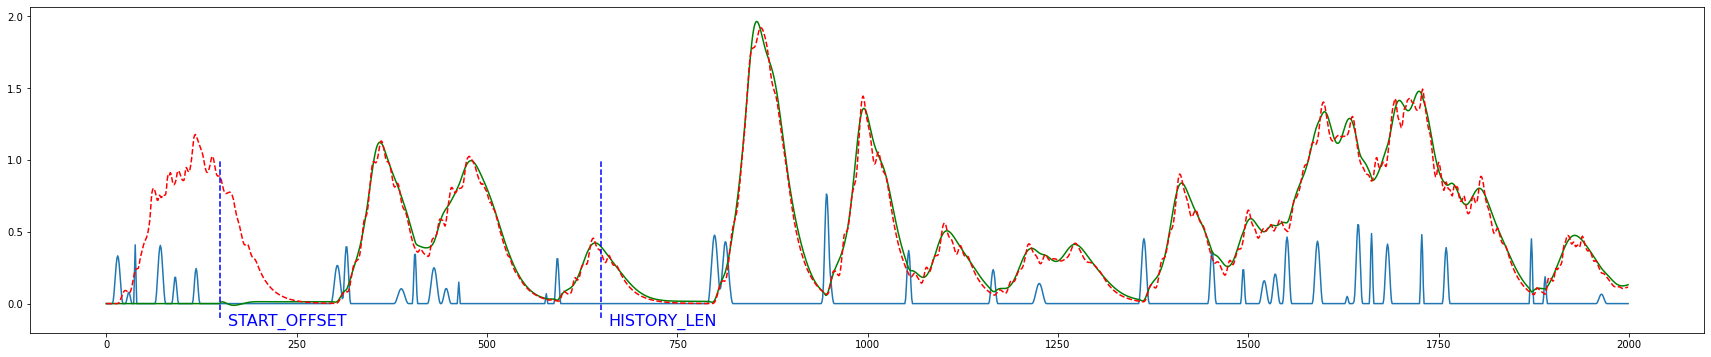

In [304]:
plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(c_prediction, 'green')
plt.plot(test_output, 'r--')
plt.plot([START_OFFSET, START_OFFSET], [-0.1, 1.0], 'b--')
plt.text(START_OFFSET + 10, -0.15, "START_OFFSET", c='b', size="16")
plt.plot([START_OFFSET + HISTORY_LEN, START_OFFSET + HISTORY_LEN], [-0.1, 1.0], 'b--')
plt.text(START_OFFSET + HISTORY_LEN + 10, -0.15, "HISTORY_LEN", c='b', size="16")
plt.show()

## Custom Tensorflow Model

Sometimes, it might be useful to define a custom model and try to capture the underlying process directly. The obvious advantage is the model explainability as we would optimize parameters with some real meaning and way less number of parameters.

The modern deep learning libraries made this process very easy as they provide automatic differentiation of any defined computation graph. Let's see how it would be done in our simple example.

First, let's capture process in a basin by sub-classing Keras layer.
We can model it as a simple recurrent cell that holds a "volume" of water as it's inner state.

In [266]:
class Basin(keras.layers.Layer):

    def __init__(self, units, runoff, **kwargs):
        self.units = units
        self.state_size = units
        self.runoff_value = runoff
        super(Basin, self).__init__(**kwargs)

    def build(self, input_shape):
        
        # These are parameters we want to search for        
        self.area = self.add_weight(
            shape=(self.units,), 
            initializer=tf.random_uniform_initializer(0, 3),
            trainable=True,
            name="area"
        )     
    
        # The "lag in discharge" parameter for each basin is tricky...
        # We can try to aproximate it with a kind of "attention head" that would focus on a element with a suitable lag
        # This implies we have to provide all possible lags in the training set input.
        # Also, the model cannot focus on the selected lag only, we should give it some "hint" to enable gradient descent.
        # Therefore, it attends to a window around the selected lag.
        self.head_position = self.add_weight(
            shape=(self.units,), 
            initializer=tf.random_uniform_initializer(0, 1), 
            trainable=True, 
            name="head_position"
        )              
                
        # This denotes the width of the attention window. It's not trainable but it can be narrowed when fine-tuning
        self.head_reach = self.add_weight(
            shape=(self.units,), 
            initializer=tf.constant_initializer(1.0),
            trainable=False,
            name="head_reach"
        )

        # These are some helpers for the window funtion
        self.head_max_position = input_shape[-1]          
        self.head_range = tf.transpose(tf.ones((self.units, self.head_max_position)) * tf.range(self.head_max_position, dtype=tf.float32))      

        self.runoff = tf.constant(self.runoff_value, shape=(self.units,))           
        self.built = True

    def call(self, inputs, states):        
        prev_state = states[0]        

        discharge = prev_state * self.runoff
        
        # This line creates the exponential window function. 
        # It teoretically never decreases to zero (and thus provides gradient), but practically, 
        # too narrow window would not result in usable gradient quite quickly
        head_mask = tf.exp(-tf.square((self.head_range - self.head_position * self.head_max_position) * self.head_reach))    
        precip = tf.matmul(inputs, head_mask) * keras.activations.relu(self.area)

        volume = prev_state + precip - discharge

        return discharge, [volume]

Now, for the model itself. 

Note the RNN wrapper that provides standard recurrent layer behavior for any custom recurrent cell:

In [273]:
MAX_LAG = 100

inputs = Input(shape=(None, MAX_LAG))
basins = Basin(9, 0.05)
basin_rnn = keras.layers.RNN(basins, return_sequences=True)(inputs)
outputs = keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=-1))(basin_rnn)

model = Model(inputs, outputs)
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        [(None, None, 100)]       0         
_________________________________________________________________
rnn_44 (RNN)                 (None, None, 9)           27        
_________________________________________________________________
lambda_19 (Lambda)           (None, None)              0         
Total params: 27
Trainable params: 18
Non-trainable params: 9
_________________________________________________________________


Now, for the training set.

We need to provide all the possible lags in the input so each basin can "choose" the correct one. This is done by rolling each input sequence `MAX_LAG`-times and stacking together.

In [242]:
extended_train_X = []

for sample in tqdm(raw_train_X):
    extended_sample = []
    for offset in range(MAX_LAG):
        x = np.roll(sample, offset)
        x[:offset] = 0
        extended_sample.append(x)
    extended_train_X.append(np.stack(extended_sample, axis=-1))

extended_train_X = np.stack(extended_train_X)
train_Y = np.vstack(raw_train_Y)

print("Input shape:", extended_train_X.shape)
print("Target shape:", train_Y.shape)


Input shape: (2000, 500, 100)
Target shape: (2000, 500)


We do not have many weights, we can try to increase the learning rate of the optimizer.

In [282]:
model.optimizer.learning_rate = 0.01
model.fit(extended_train_X, train_Y, epochs=2, validation_split=0.1)

57/57 [==============================] - 36s 627ms/step - loss: 0.0200 - val_loss: 0.0037


In [278]:
# keras.backend.set_value(basins.head_reach, np.full(9, 2.0))

In [283]:
model.optimizer.learning_rate = 0.001
model.fit(extended_train_X, train_Y, epochs=2, validation_split=0.1)

57/57 [==============================] - 34s 591ms/step - loss: 0.0030 - val_loss: 0.0029


In [284]:
TEST_SEQ_LEN = 2000
test_input = generate_precipitation(TEST_SEQ_LEN, 0.02)
test_output = generate_discharge(BASINS, test_input, 0.05)

extended_sample = []
for offset in range(MAX_LAG):
    x = np.roll(test_input, offset)
    x[:offset] = 0
    extended_sample.append(x)

extended_sample = np.stack(extended_sample, axis=-1)

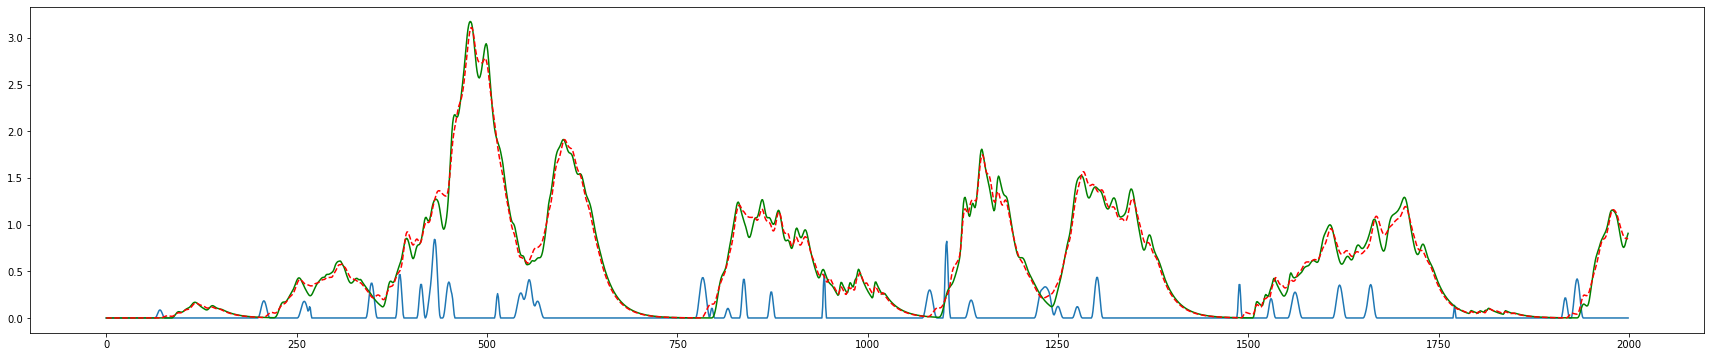

In [285]:
plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(model.predict(np.expand_dims(extended_sample, 0))[0], 'green')
plt.plot(test_output, 'r--')
plt.show()

In [287]:
sorted(
    ((area, lag * MAX_LAG) for area, lag in zip(model.weights[0].numpy(), model.weights[1].numpy())),
    key=lambda b: b[1]
)

[(2.903404, 19.97685134410858),
 (3.2215064, 31.675729155540466),
 (2.2357264, 39.027222990989685),
 (-0.0009135441, 41.98805093765259),
 (2.7453337, 43.00761520862579),
 (3.344522, 64.9448812007904),
 (1.0850941, 77.45372653007507),
 (-0.00051861024, 90.98460078239441),
 (0.76884156, 101.18368864059448)]

In [288]:
BASINS

array([[ 1,  5],
       [ 2, 20],
       [ 2, 30],
       [ 1, 35],
       [ 3, 41],
       [ 2, 45],
       [ 1, 54],
       [ 2, 65],
       [ 1, 75]])